<a href="https://colab.research.google.com/github/ryandhikafm/DTI-Telkom/blob/Classification/Classification_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classification

Dataset bisa diakses melalui link https://www.kaggle.com/janiobachmann/bank-marketing-dataset atau https://archive.ics.uci.edu/ml/datasets/Bank+Marketing

Kali ini saya ingin mengklasifikasi deposit (yes, no) Binary classification menggunakan 3 algoritma yaitu decision tree, naive bayes, dan random forest. Ketiga algoritma tsb tidak perlu mengukur jarak euclidean distance. Maka dari itu, tidak ada tahapan feature scalling (normalization, standardization) pada kasus ini. Algoritma lain yang tidak perlu mengukur jarak adalah Xgboost, Linear Discriminant Analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('bank.csv')

In [3]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,yes


In [5]:
df.info()

#Tidak ada nilai yang kosong

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11162 non-null  int64 
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(7), object(10)
memory usage: 1.4+ MB


In [6]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
age,11162.0,41.231948,11.913369,18.0,32.0,39.0,49.00,95.0
balance,11162.0,1528.538524,3225.413326,-6847.0,122.0,550.0,1708.00,81204.0
day,11162.0,15.658036,8.420740,1.0,8.0,15.0,22.00,31.0
duration,11162.0,371.993818,347.128386,2.0,138.0,255.0,496.00,3881.0
campaign,11162.0,2.508421,2.722077,1.0,1.0,2.0,3.00,63.0
pdays,11162.0,51.330407,108.758282,-1.0,-1.0,-1.0,20.75,854.0
previous,11162.0,0.832557,2.292007,0.0,0.0,0.0,1.00,58.0


## Data Preprocessing

In [7]:
# Encode fitur deposit

from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
fig = plt.figure(figsize=(12,8))
df['deposit'] = LabelEncoder().fit_transform(df['deposit'])

<Figure size 864x576 with 0 Axes>

In [8]:
# Memisahkan kolom numerik 
numeric_df = df.select_dtypes(exclude="object")

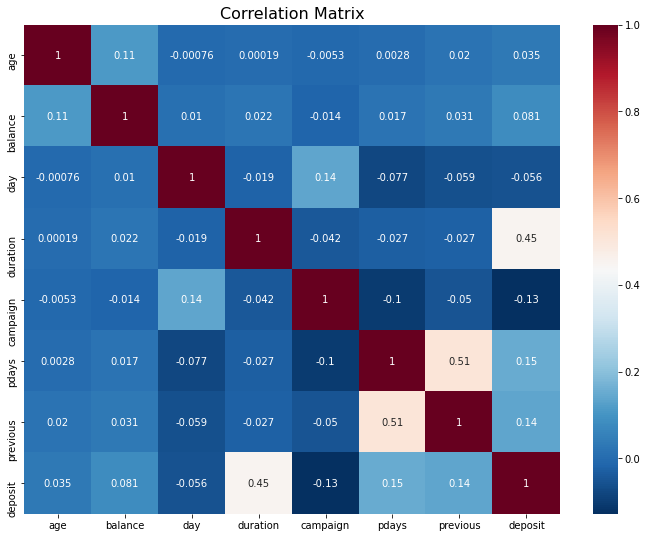

In [9]:
corr_numeric = numeric_df.corr()

f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corr_numeric, annot=True, cbar=True, cmap="RdBu_r")
plt.title("Correlation Matrix", fontsize=16)
plt.show()

In [10]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,1
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,1
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,1
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,1
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,1


In [11]:
#Encode kolom kategorikal

encoder = OneHotEncoder(sparse=False)

# Encode Categorical Data
df_encoded = pd.DataFrame(encoder.fit_transform(df[['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']]))
df_encoded.columns = encoder.get_feature_names(['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome'])

In [12]:
# Ganti kolom kategorik dengan data yang sudah ter-encode
df.drop(['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome'] ,axis=1, inplace=True)
df_encoded = pd.concat([df, df_encoded], axis=1)

# Show Encoded Dataframe
df_clean = df_encoded
df_clean

,age,balance,day,duration,campaign,pdays,previous,deposit,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_divorced,marital_married,marital_single,education_primary,education_secondary,education_tertiary,education_unknown,default_no,default_yes,housing_no,housing_yes,loan_no,loan_yes,contact_cellular,contact_telephone,contact_unknown,month_apr,month_aug,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
0,59,2343,5,1042,1,-1,0,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,56,45,5,1467,1,-1,0,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,41,1270,5,1389,1,-1,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,55,2476,5,579,1,-1,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,54,184,5,673,2,-1,0,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11157,33,1,20,257,1,-1,0,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
11158,39,733,16,83,4,-1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
11159,32,29,19,156,2,-1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
11160,43,0,8,9,2,172,5,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


## Modeling

In [13]:
# Set Training and Testing Data (80:20)
from sklearn.model_selection import StratifiedShuffleSplit, cross_val_score
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_set, test_set in split.split(df_clean, df_clean["deposit"]):
    df_clean_train_set = df_clean.loc[train_set]
    df_clean_test_set = df_clean.loc[test_set]

In [14]:
X_train = df_clean_train_set.drop("deposit", axis=1)
y_train =df_clean_train_set["deposit"].copy()
X_test = df_clean_test_set.drop("deposit", axis=1)
y_test = df_clean_test_set["deposit"].copy()

In [15]:
X_train['campaign'].value_counts() / len(X_train)

1     0.431179
2     0.273043
3     0.117370
4     0.068653
5     0.034270
6     0.023407
7     0.011983
8     0.011087
9     0.006048
10    0.004256
11    0.003472
13    0.002576
12    0.002128
17    0.001456
15    0.001232
14    0.001232
16    0.000896
18    0.000672
21    0.000672
24    0.000560
30    0.000448
20    0.000448
19    0.000336
22    0.000336
26    0.000336
23    0.000336
25    0.000336
43    0.000224
29    0.000224
32    0.000224
63    0.000112
33    0.000112
41    0.000112
31    0.000112
27    0.000112
Name: campaign, dtype: float64

In [16]:
X_test['campaign'].value_counts() / len(X_test)

1     0.424541
2     0.264219
3     0.122257
4     0.070757
5     0.032244
6     0.025078
7     0.014330
8     0.012987
9     0.008061
10    0.006270
12    0.004478
11    0.004030
13    0.003135
14    0.001791
21    0.000896
18    0.000896
19    0.000896
15    0.000896
16    0.000448
20    0.000448
22    0.000448
17    0.000448
28    0.000448
Name: campaign, dtype: float64

### Decision Tree

In [19]:
# Import Module
from sklearn import tree

# Modeling Decision Tree
dtc = tree.DecisionTreeClassifier(min_impurity_decrease=0.01)
dtc.fit(X_train, y_train)

# Predict to Test Data 
y_pred_dtc = dtc.predict(X_test)

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)


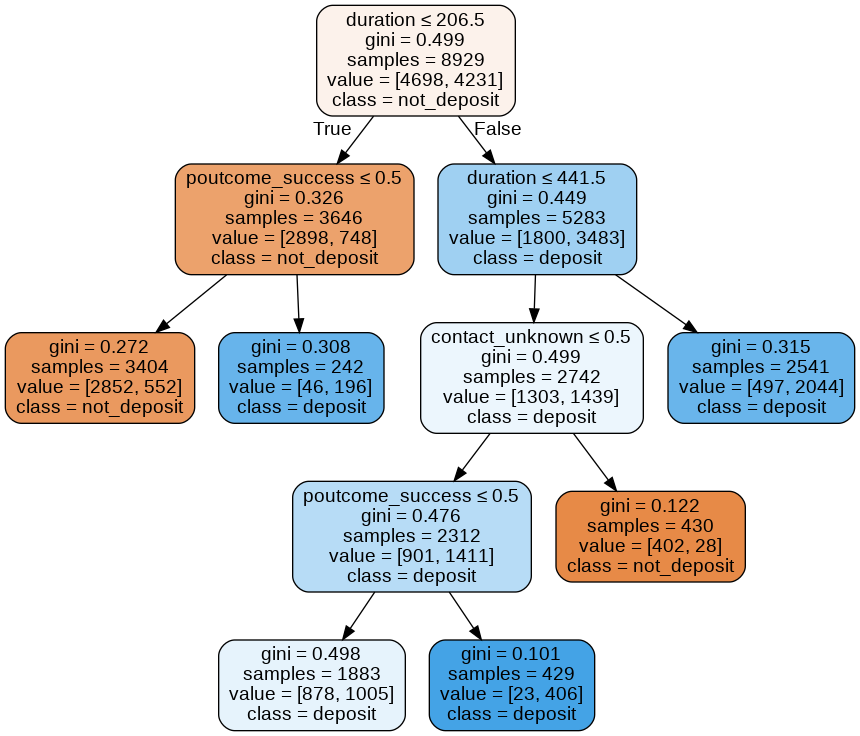

In [20]:
# Visualize Tree

from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

dot_data = StringIO()
export_graphviz(dtc, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,
                class_names=['not_deposit', 'deposit'],
                feature_names=['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous', 'job_admin', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 
                               'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'job_unknown',
                               'marital_divorced', 'marital_married', 'marital_single', 'education_primary', 'education_secondary', 'education_tertiary', 'education_unknown', 
                               'default_no', 'default_yes', 'housing_no', 'housing_yes', 'loan_no', 'loan_yes', 'contact_cellular', 'contact_telephone', 'contact_unknown', 'month_apr',
                               'month_aug', 'month_dec', 'month_feb', 'month_jan', 'month_jul', 'month_jun', 'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep', 'poutcome_failure',
                               'poutcome_other', 'poutcome_success', 'poutcome_unknown'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

In [21]:
# Import Module
from sklearn import metrics

# Show the Confussion Matrix
cm_dtc = metrics.confusion_matrix(y_test, y_pred_dtc)
cm_dtc

array([[815, 360],
       [150, 908]])

In [22]:
# Show the Accuracy, Precision, Recall
acc_dtc = metrics.accuracy_score(y_test, y_pred_dtc)
prec_dtc = metrics.precision_score(y_test, y_pred_dtc)
rec_dtc = metrics.recall_score(y_test, y_pred_dtc)
f1_dtc = metrics.f1_score(y_test, y_pred_dtc)
kappa_dtc = metrics.cohen_kappa_score(y_test, y_pred_dtc)

print("Accuracy:", acc_dtc)
print("Precision:", prec_dtc)
print("Recall:", rec_dtc)
print("F1 Score:", f1_dtc)
print("Cohens Kappa Score:", kappa_dtc)

Accuracy: 0.7716077026421854
Precision: 0.7160883280757098
Recall: 0.8582230623818525
F1 Score: 0.7807394668959587
Cohens Kappa Score: 0.5464400785385145


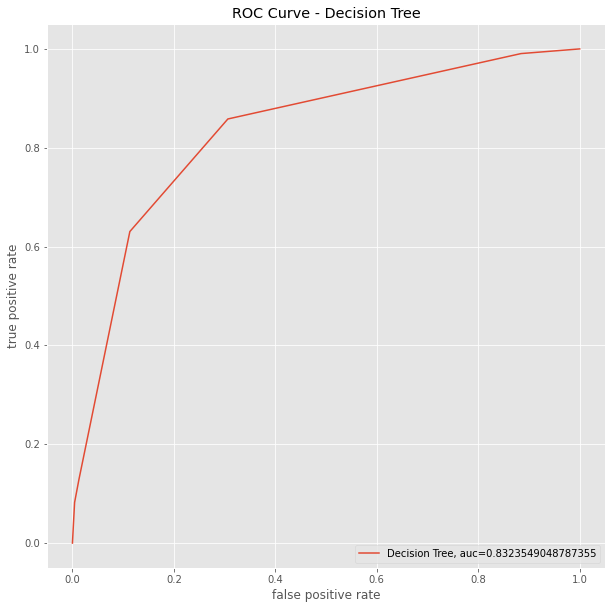

In [23]:
# Import Visualization Package
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Set Size and Style
plt.rcParams['figure.figsize'] = (10, 10)
plt.style.use('ggplot')

# Visualize ROC Curve
y_pred_dtc_proba = dtc.predict_proba(X_test)[::,1]
fprdtc, tprdtc, _ = metrics.roc_curve(y_test,  y_pred_dtc_proba)
aucdtc = metrics.roc_auc_score(y_test, y_pred_dtc_proba)
plt.plot(fprdtc,tprdtc,label="Decision Tree, auc="+str(aucdtc))
plt.title('ROC Curve - Decision Tree')
plt.xlabel('false positive rate') 
plt.ylabel('true positive rate')
plt.legend(loc=4)
plt.show()

### Naive Bayes

In [24]:
# Import Module
from sklearn.naive_bayes import GaussianNB 

# Modeling Naive Bayes Classifier
gnb = GaussianNB()
gnb.fit(X_train, y_train)

# Predict to Test Data
y_pred_gnb= gnb.predict(X_test)

In [25]:
# Show the Confussion Matrix
cm_gnb = metrics.confusion_matrix(y_test, y_pred_gnb)
cm_gnb

array([[991, 184],
       [406, 652]])

In [26]:
acc_gnb = metrics.accuracy_score(y_test, y_pred_gnb)
prec_gnb = metrics.precision_score(y_test, y_pred_gnb)
rec_gnb = metrics.recall_score(y_test, y_pred_gnb)
f1_gnb = metrics.f1_score(y_test, y_pred_gnb)
kappa_gnb = metrics.cohen_kappa_score(y_test, y_pred_gnb)

print("Accuracy:", acc_gnb)
print("Precision:", prec_gnb)
print("Recall:", rec_gnb)
print("F1 Score:", f1_gnb)
print("Cohens Kappa Score:", kappa_gnb)

Accuracy: 0.7357814599193909
Precision: 0.7799043062200957
Recall: 0.6162570888468809
F1 Score: 0.6884899683210136
Cohens Kappa Score: 0.46451405220283815


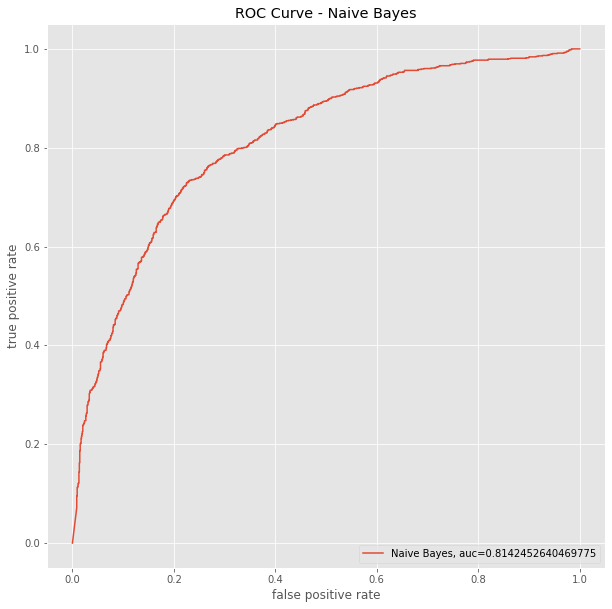

In [27]:
# ROC Curve
y_pred_gnb_proba = gnb.predict_proba(X_test)[::,1]
fprgnb, tprgnb, _ = metrics.roc_curve(y_test,  y_pred_gnb_proba)
aucgnb = metrics.roc_auc_score(y_test, y_pred_gnb_proba)
plt.plot(fprgnb,tprgnb,label="Naive Bayes, auc="+str(aucgnb))
plt.title('ROC Curve - Naive Bayes')
plt.xlabel('false positive rate') 
plt.ylabel('true positive rate')
plt.legend(loc=4)
plt.show()

### Random Forest

In [28]:
from sklearn.ensemble import RandomForestClassifier

# Modeling Random Forest Classifier
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

# Predict to Test Data
y_pred_rf= rf.predict(X_test)

In [29]:
# Show the Confussion Matrix
cm_rf = metrics.confusion_matrix(y_test, y_pred_rf)
cm_rf

array([[982, 193],
       [122, 936]])

In [30]:
acc_rf = metrics.accuracy_score(y_test, y_pred_rf)
prec_rf = metrics.precision_score(y_test, y_pred_rf)
rec_rf = metrics.recall_score(y_test, y_pred_rf)
f1_rf = metrics.f1_score(y_test, y_pred_rf)
kappa_rf = metrics.cohen_kappa_score(y_test, y_pred_rf)

print("Accuracy:", acc_rf)
print("Precision:", prec_rf)
print("Recall:", rec_rf)
print("F1 Score:", f1_rf)
print("Cohens Kappa Score:", kappa_rf)

Accuracy: 0.8589341692789969
Precision: 0.829052258635961
Recall: 0.8846880907372401
F1 Score: 0.8559670781893003
Cohens Kappa Score: 0.7180337423890817


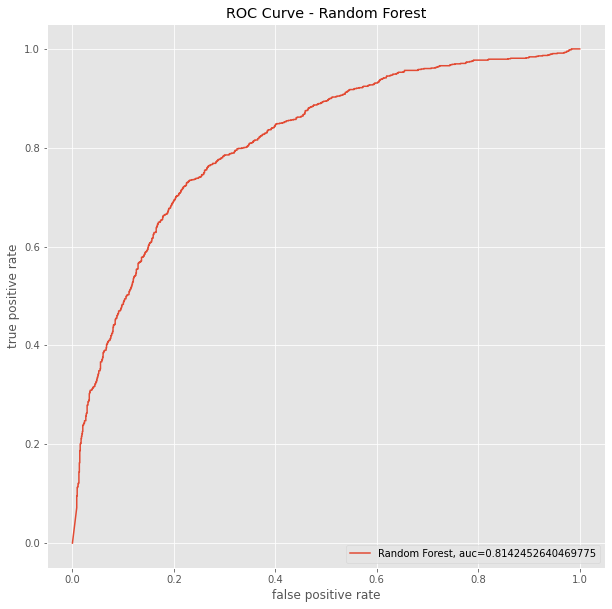

In [31]:
# ROC Curve
y_pred_rf_proba = gnb.predict_proba(X_test)[::,1]
fprrf, tprrf, _ = metrics.roc_curve(y_test,  y_pred_rf_proba)
aucrf = metrics.roc_auc_score(y_test, y_pred_rf_proba)
plt.plot(fprrf,tprrf,label="Random Forest, auc="+str(aucrf))
plt.title('ROC Curve - Random Forest')
plt.xlabel('false positive rate') 
plt.ylabel('true positive rate')
plt.legend(loc=4)
plt.show()

## Model Comparison

In [32]:
print("Decision Tree Accuracy =",acc_dtc)
print("Decision Tree Precision =",prec_dtc)
print("Decision Tree Recall =",rec_dtc)
print("Decision Tree F1-Score =", f1_dtc)
print("_______________________")
print("Naive Bayes Accuracy =", acc_gnb)
print("Naive Bayes Precision =", prec_gnb)
print("Naive Bayes Recall =", rec_gnb)
print("Naive Bayes F1-Score =", f1_gnb)
print("_______________________")
print("Random Forest Accuracy =", acc_rf)
print("Random Forest Precision =", prec_rf)
print("Random Forest Recall =", rec_rf)
print("Random Forest F1-Score =", f1_rf)

Decision Tree Accuracy = 0.7716077026421854
Decision Tree Precision = 0.7160883280757098
Decision Tree Recall = 0.8582230623818525
Decision Tree F1-Score = 0.7807394668959587
_______________________
Naive Bayes Accuracy = 0.7357814599193909
Naive Bayes Precision = 0.7799043062200957
Naive Bayes Recall = 0.6162570888468809
Naive Bayes F1-Score = 0.6884899683210136
_______________________
Random Forest Accuracy = 0.8589341692789969
Random Forest Precision = 0.829052258635961
Random Forest Recall = 0.8846880907372401
Random Forest F1-Score = 0.8559670781893003


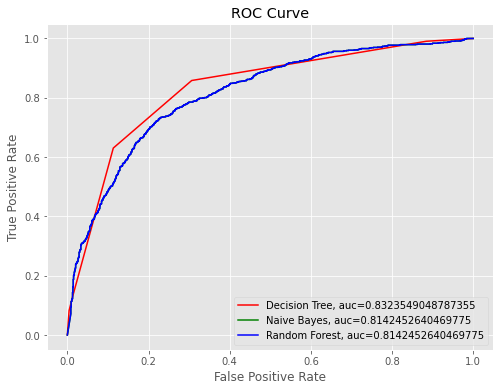

In [33]:
plt.figure(figsize=(8,6))
plt.plot(fprdtc,tprdtc,label="Decision Tree, auc="+str(aucdtc), color ='red')
plt.plot(fprgnb,tprgnb,label="Naive Bayes, auc="+str(aucgnb), color ='green')
plt.plot(fprrf,tprrf,label="Random Forest, auc="+str(aucrf), color = 'blue')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc=4)
plt.show()

Dari ketiga algoritma didapatkan hasil bahwa algoritma Random Forest merupakan algoritma terbaik untuk kasus ini